## 📚 Prerequisites

Before executing this notebook, make sure you have properly set up your Azure Services, created your Conda environment, and configured your environment variables as per the instructions provided in the [README.md](README.md) file.


# 📕 Table of Contents

1. [Understanding Quantitative Measures of Relevance](#-Understanding-Quantitative-Measures-of-Relevance)
2. [Dataset Creation](#-Dataset-Creation)
3. [0. Benchmark Setup](#-0-Benchmark-Setup)
4. [1. Generate Corpus of Documents](#-1-Generate-Corpus-of-Documents)
5. [2. Generate Queries for Evaluation](#-2-Generate-Queries-for-Evaluation)
6. [3. Generate Relevance Judgments](#-3-Generate-Relevance-Judgments)
7. [4. Generate Rankings for Evaluation](#-4-Generate-Rankings-for-Evaluation)
8. [5. Run Evaluation](#-5-Run-Evaluation)
9. [Interpreting the Results](#Interpreting-the-Results)
10. [Customizing the Evaluation](#Customizing-the-Evaluation)

> **By the end of this notebook**, you’ll understand how to build both a **fully customized benchmark evaluation flow** using the SDK and a **scalable low-code pipeline** using native algorithms with Azure AI Search and GPT models to generate our evaluation dataset. 

## 📊 Understanding Quantitative Measures of Relevance

In order to evaluate the effectiveness of our search system, we use several metrics that measure the relevance of the results it returns. These metrics help us understand how well our system is performing and guide us in tuning it for better performance.

+ **NDCG@10**: Normalized Discounted Cumulative Gain at 10 (NDCG@10) is a metric that assesses the effectiveness of a retrieval system at finding and correctly ordering the top 10 documents. The score ranges from 0 to 100, with higher scores indicating that the system's ordered list of documents closely matches the ideal order. This metric is widely used because it balances the need for precision (returning relevant results) with the need for proper sequencing (ordering the results correctly).

- **NDCG@3**: NDCG@3 is similar to NDCG@10, but it focuses on the top 3 documents. This metric is particularly relevant in contexts where it's crucial to have the highest accuracy in the topmost results, such as in generative AI applications. NDCG@3 measures the system's ability to identify and correctly rank the three most relevant documents.

+ **Recall@50**: Recall@50 measures the proportion of high-quality documents identified within the top 50 results. It's calculated by counting the number of documents rated as high quality by a scoring prompt and dividing this by the total number of known good documents for a given query. This metric is useful for assessing the system's ability to retrieve a broad set of relevant documents from a large pool.

To automate the evaluation process, we use supervised tuning techniques. These techniques involve training a model on a labeled dataset, where the labels indicate the relevance of the documents to the queries. The model learns to predict the relevance of a document to a query, and we can then use these predictions to calculate the metrics above. This allows us to measure the relevance of our queries in an automated and scalable way.

## 🗃️ Dataset Creation

To assess the qualitative performance of our search store in alignment with the BEIR framework, we follow a three-step process to generate our evaluation dataset:

1. **Corpus Creation:**
   We begin by extracting document chunks from our Azure Search index. These chunks are consolidated into a corpus file (`corpus.jsonl`), ensuring that the foundational set of documents is standardized and comprehensive for subsequent evaluation.

2. **Query Generation:**
   Next, we utilize GPT-4o to generate a diverse set of queries based on five carefully selected diagnosis and medication scenarios from our medical index. This targeted approach ensures that the queries are medically relevant and reflective of real-world clinical information needs. The generated queries are stored in `queries.jsonl`.

3. **Relevance Judgments:**
   Finally, we employ an LLM-as-a-judge to evaluate the relevance of the documents with respect to each query. This evaluation produces relevance judgments that are saved in `qrel.jsonl`. These qrels form the basis for computing our performance metrics, including NDCG@10, NDCG@3, and Recall@50.
   3. 
4. **Ranking Generation:**
    We generate rankings for each query using the following retrieval algorithms:
    - **Keyword Search**: Basic keyword (lexical) search.
    - **Vector Search**: Search using a vector query.
    - **Hybrid Search**: Hybrid search using both keyword and vector queries.
    - **Hybrid + Semantic Search**: Hybrid search using both keyword and vector queries with semantic reranking.

You can use the below cells to generate your own dataset, please uncomment the code and run it. The dataset will be saved in the `evals/benchmark/medindexer` directory, where our existing datasets have been curated.


## ⚙️ 0. Benchmark Setup

First we run all the imports and setup of our benchmark evaluator class, this will take care of the methods we created later to help with the generation of our dataset.

In [1]:
from dotenv import load_dotenv
import os
from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential
import json
from src.evals.benchmark import BenchmarkOrchestrator

load_dotenv()

# Setup configuration variables for Azure and MedImageInsight
search_endpoint = os.getenv("AZURE_AI_SEARCH_SERVICE_ENDPOINT")
search_admin_key = os.getenv("AZURE_AI_SEARCH_ADMIN_KEY")
search_index_name = os.getenv("AZURE_IMAGES_SEARCH_INDEX_NAME", "ai-policies-index")
root = os.path.dirname(os.getcwd())
search_client = SearchClient(
    endpoint=search_endpoint,
    index_name=search_index_name,
    credential=AzureKeyCredential(search_admin_key)
)

dataset_dir = "evals/benchmark/medindexer"
benchmark_orchestrator = BenchmarkOrchestrator(search_client, dataset_dir)

Templates found: ['evaluator_system_prompt.jinja', 'evaluator_user_prompt.jinja', 'formulator_system_prompt.jinja', 'formulator_user_prompt.jinja', 'ner_clinician_system.jinja', 'ner_clinician_user.jinja', 'ner_patient_system.jinja', 'ner_patient_user.jinja', 'ner_physician_system.jinja', 'ner_physician_user.jinja', 'ner_system_prompt.jinja', 'ner_user_prompt.jinja', 'prior_auth_o1_user_prompt.jinja', 'prior_auth_o1_user_prompt_b.jinja', 'prior_auth_system_prompt.jinja', 'prior_auth_user_prompt.jinja', 'query_classificator_system_prompt.jinja', 'query_classificator_user_prompt.jinja', 'query_expansion_system_prompt.jinja', 'query_expansion_user_prompt.jinja', 'query_generation_eval_system_prompt.jinja', 'query_generation_eval_user_prompt.jinja', 'query_relevance_eval_system_prompt.jinja', 'query_relevance_eval_user_prompt.jinja', 'summarize_policy_system.jinja', 'summarize_policy_user.jinja']


## 📚 1. Generate Corpus of Documents

We want to use the documents we created as a result of medIndexer workload, and our benchmark evaluation class is pointed to the `clinical-policies-index` index, these documents are subject to change based on how you choose to index, extract, and split your documents.

If you wish to run this on your infrastructure, be sure to set `run_corpus=True` in the method below.

In [3]:
benchmark_orchestrator.generate_corpus(run_corpus=False)

Corpus saved to /Users/marcjimz/Documents/Development/aihlsignited-medindexer/evals/benchmark/medindexer/corpus.jsonl


## ❓ 2. Generate Queries for Evaluation

We now want to make use of GPT large language models to help us with generation of queries we can ask of our search store, with an inclination towards the use cases we benchmarked. This will help us evaluate the performance of our search store in a more targeted manner, however consider expanding the search query to a much broader set of use cases in the medical domain as you need.

Refer to our prompt manager built under `src/pipeline/promptEngineering/prompt_manager.py` to see how we are able to generate these queries.


<details>
  <summary><code>query_generation_eval_user_prompt.jinja</code> (Click to expand!)</summary>


```jinja
## Role:
You are a query generation expert for a prior authorization evaluation system, tasked with creating a list of concise search queries.

## Task:
Based on the following use case—which includes a diagnosis and a medication—generate a list of search queries that would effectively retrieve relevant documents from a corpus of medical policies.

## Instructions:
- Combine the provided "Diagnosis" and "Medication" fields into multiple search queries.
- Use appropriate medical terminology and, if useful, include synonyms.
- The queries should be clear, specific, and aimed at finding documents related to prior authorization decisions for the given case.
- Return your result as a JSON object with the key "queries" and a list of query strings as the value.
- Do not wrap the output in any ``` tags.

Example:
Input:
Diagnosis: "Severe Atopic Dermatitis"
Medication: "Dupilumab"
Output:

{
  "queries": [
    "Severe atopic dermatitis Dupilumab prior authorization criteria",
    "Dupilumab treatment guidelines for severe atopic dermatitis",
    "Prior authorization requirements for Dupilumab in atopic dermatitis"
  ]
}

Now generate a list of queries for the following:
Diagnosis: {{ diagnosis }}
Medication: {{ medication }}
```

</details>

If you wish to run this on your infrastructure, be sure to set `run_queries=True` in the method below.


In [2]:
await benchmark_orchestrator.generate_queries(run_queries=False)

2025-04-02 12:41:23,671 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-02 12:41:23 (aoai_helper.py:generate_chat_response:534)
2025-04-02 12:41:23,671 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 12:41:23 (aoai_helper.py:generate_chat_response:591)
2025-04-02 12:41:27,140 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-02 12:41:27 (Duration: 3.47 seconds) (aoai_helper.py:generate_chat_response:645)
2025-04-02 12:41:27,142 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-02 12:41:27 (aoai_helper.py:generate_chat_response:534)
2025-04-02 12:41:27,142 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 12:41:27 (aoai_helper.py:generate_chat_response:591)
2025-04-02 12:41:28,891 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-02 12:41:28 (Duration: 1.75 seconds) (aoai_helper.py:generate

Queries saved to /Users/marcjimz/Documents/Development/aihlsignited-medindexer/evals/benchmark/medindexer/queries.jsonl


## 3. ⚖️ Generate Relevance Judgments

We now want to use both our corpus of documents and our queries to execute exactly which documents are relevant to which queries, this will help us evaluate the performance of our search store in a more targeted manner. We create a prompt inspired by our own published `RelevanceEvaluator` which is available today in AI Foundry, and we framed it for our use case.

<details>
  <summary><code>relevance_judgment_eval_user_prompt.jinja</code> (Click to expand!)</summary>

  
```jinja
# Definition
**Relevance** refers to how effectively a response addresses a question. It assesses the accuracy, completeness, and direct relevance of the response based solely on the given information.

# Ratings
## [Relevance: 1] (Irrelevant Response)
**Definition:** The response is unrelated to the question. It provides information that is off-topic and does not attempt to address the question posed.

**Examples:**
  **Query:** What is the team preparing for?
  **Response:** I went grocery shopping yesterday evening.

  **Query:** When will the company's new product line launch?
  **Response:** International travel can be very rewarding and educational.

## [Relevance: 2] (Incorrect Response)
**Definition:** The response attempts to address the question but includes incorrect information. It provides a response that is factually wrong based on the provided information.

**Examples:**
  **Query:** When was the merger between the two firms finalized?
  **Response:** The merger was finalized on April 10th.

  **Query:** Where and when will the solar eclipse be visible?
  **Response:** The solar eclipse will be visible in Asia on December 14th.

## [Relevance: 3] (Incomplete Response)
**Definition:** The response addresses the question but omits key details necessary for a full understanding. It provides a partial response that lacks essential information.

**Examples:**
  **Query:** What type of food does the new restaurant offer?
  **Response:** The restaurant offers Italian food like pasta.

  **Query:** What topics will the conference cover?
  **Response:** The conference will cover renewable energy and climate change.

## [Relevance: 4] (Complete Response)
**Definition:** The response fully addresses the question with accurate and complete information. It includes all essential details required for a comprehensive understanding, without adding any extraneous information.

**Examples:**
  **Query:** What type of food does the new restaurant offer?
  **Response:** The new restaurant offers Italian cuisine, featuring dishes like pasta, pizza, and risotto.

  **Query:** What topics will the conference cover?
  **Response:** The conference will cover renewable energy, climate change, and sustainability practices.

## [Relevance: 5] (Comprehensive Response with Insights)
**Definition:** The response not only fully and accurately addresses the question but also includes additional relevant insights or elaboration. It may explain the significance, implications, or provide minor inferences that enhance understanding.

**Examples:**
  **Query:** What type of food does the new restaurant offer?
  **Response:** The new restaurant offers Italian cuisine, featuring dishes like pasta, pizza, and risotto, aiming to provide customers with an authentic Italian dining experience.

  **Query:** What topics will the conference cover?
  **Response:** The conference will cover renewable energy, climate change, and sustainability practices, bringing together global experts to discuss these critical issues.

# Data

## Please assess the relevance of the given **CORPUS** entries to the **QUERY** based on the definitions provided above. You will evaluate each entry in the **CORPUS** based on how well it addresses the **QUERY**. Your evaluation should be guided by the definitions and examples provided.

#### CORPUS:

{{ corpus }}

#### QUERY:

{{ query }}

#### QUERY ID:

{{ query_id }}

# Tasks
## Please provide your assessment Score for the CORPUS entries in relation to the QUERY based on the Definitions above. Your output should include the following information:
- **thought_chain**: To improve the reasoning process, think step by step and include a step-by-step explanation of your thought process as you analyze the data based on the definitions. Keep it brief and start your ThoughtChain with "Let's think step by step:" and limit your reasoning to no more than 1000 characters.
- **explanation**: a very short explanation of why you think the input Data should get that Score.
- **relevant_score**: based on your previous analysis, provide your Score. The Score you give MUST be a integer score (i.e., "1", "2"...) based on the levels of the definitions.
- **document**: the ID of the document ID
- **query**: the ID of the query ID
- **relevant**: relevant based on the score you give, if 3 or above you can score it as relevant

## Please provide your answers for each query on the JSON entity you generate per query. Refer to the example below.

# Output

## Example:

### Input:

    #### CORPUS:

    [
      {"id": "d1", "chunk": "guidelines for Crohn's disease and Adalimumab are"},
      {"id": "d2", "chunk": "noted below. In cases where the approval is authorized"},
      {"id": "d3", "chunk": "10. Behcet's Disease. Approve for the duration noted"}
    ]

    #### QUERY:

    Crohn's disease Adalimumab prior authorization criteria

    #### QUERY ID:

    q1

### Output (make sure the list object is completely JSON formatted and compliant with JSON loaders):

    [
      {"query": "q1", "document": "d1", "relevant": 1, "relevant_score" : 5, "thought_chain" : "..", "explanation" : ".."},
      {"query": "q1", "document": "d2", "relevant": 0, "relevant_score" : 1, "thought_chain" : "..", "explanation" : ".."},
      {"query": "q1", "document": "d3", "relevant": 0, "relevant_score" : 1, "thought_chain" : "..", "explanation" : ".."}
    ]
```

</details>

In [2]:
with open(os.path.join(root, dataset_dir, "corpus.jsonl"), "r") as f:
    corpus_data = [
        {k: d[k] for k in ("chunk", "id", "title", "chunk_id") if k in d}
        for d in (json.loads(line) for line in f if line.strip())
    ]

with open(os.path.join(root, dataset_dir, "queries.jsonl"), "r") as f:
    queries_data = [json.loads(line) for line in f if line.strip()]

In [3]:
await benchmark_orchestrator.generate_qrels(corpus_data, queries_data, run_relevance=True)

Query q1 Blocks:   0%|          | 0/1 [00:00<?, ?it/s]2025-04-02 12:43:54,080 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 12:43:54 (aoai_helper.py:generate_chat_response_no_history:422)

Processing Queries: 100%|██████████| 1/1 [00:05<00:00,  5.38s/it]

Qrels saved to /Users/marcjimz/Documents/Development/aihlsignited-medindexer/evals/benchmark/medindexer/qrels.jsonl


## 4. 🏆 Generate rankings for evaluation

Rankings are generated using the corpus and queries we have created, this will help us evaluate the performance of our search store in a more targeted manner. We retrieve the relevant documents for each and every query we generated using the different algorithms available to us and record the rankings.

- **Keyword Search**: Basic keyword (lexical) search.
- **Vector Search**: Search using a vector query.
- **Hybrid Search**: Hybrid search using both keyword and vector queries.
- **Hybrid + Semantic Search**: Hybrid search using both keyword and vector queries with semantic reranking.

In [4]:
benchmark_orchestrator.generate_rankings(run_rankings=False)

Processed query q1
Processed query q2
Processed query q3
Processed query q4
Processed query q5
Processed query q6
Processed query q7
Processed query q8
Processed query q9
Processed query q10
Processed query q11
Processed query q12
Processed query q13
Processed query q14
Processed query q15
Processed query q16
Processed query q17
Processed query q18
Processed query q19
Processed query q20
Processed query q21
Processed query q22
Processed query q23
Processed query q24
Processed query q25
Processed query q26
Processed query q27
Processed query q28
Processed query q29
Processed query q30
Processed query q31
Processed query q32
Processed query q33
Processed query q34
Processed query q35
Rankings files have been generated.


## 5. ▶️ Run Evaluation

Now with our corpus generated, relevance rankings queries, we can make use of the `BEIR` framework to evaluate the performance of our search store. We will run the evaluation for the following retrieval metrics:

- **NDCG@3**: Normalized Discounted Cumulative Gain at 3.
- **NDCG@10**: Normalized Discounted Cumulative Gain at 10.
- **Recall@50**: Recall at 50.

Evaluation Metrics:
           BEIR-Keyword  BEIR-Vector  BEIR-Hybrid (Keyword + Vector)  \
NDCG@3          0.63841      0.76906                         0.78106   
NDCG@10         0.69166      0.71201                         0.83195   
Recall@10       0.76512      0.70012                         0.87894   

           BEIR-Hybrid + Semantic  
NDCG@3                    0.70674  
NDCG@10                   0.74295  
Recall@10                 0.81668  


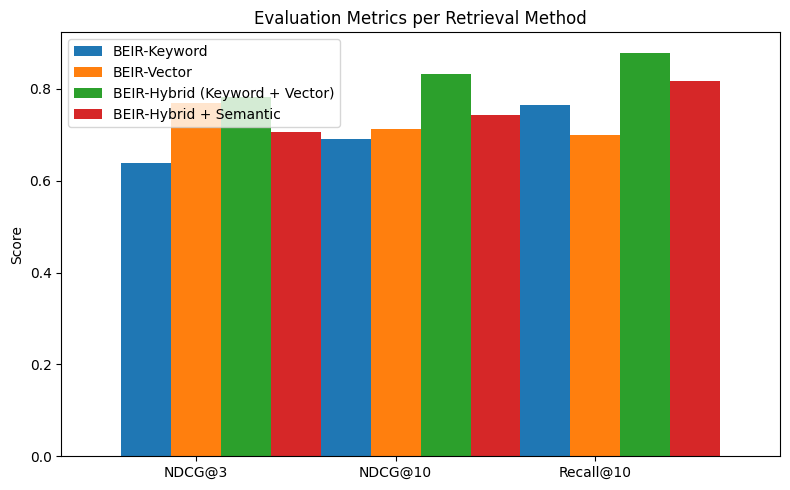

In [15]:
benchmark_orchestrator.generate_evaluation_metrics()

# 🔍 Interpreting the Results

From the chart and metrics above, we see that:

- **Keyword-only (BM25) retrieval** achieves moderate performance (NDCG@3 ≈ 0.64, NDCG@10 ≈ 0.69) and relatively high Recall@10 (≈ 0.76). This suggests that strict lexical matching catches many relevant documents but may not prioritize them perfectly at the top (as reflected by somewhat lower NDCG scores).

- **Vector-only retrieval** slightly improves NDCG@3 and NDCG@10 over keyword-only (NDCG@3 ≈ 0.77, NDCG@10 ≈ 0.71) but actually has a lower Recall@10 (≈ 0.70). The improved NDCG but drop in recall indicates that dense retrieval can find *some* relevant documents more effectively but may miss certain others, possibly due to insufficient domain-specific training or conceptual coverage.

- **Hybrid (Keyword + Vector)** shows the best scores across the board, with the highest NDCG@3 (≈ 0.78), NDCG@10 (≈ 0.83), and Recall@10 (≈ 0.88). This confirms a recurring finding in biomedical information retrieval: combining lexical and dense retrieval balances term-precision with conceptual recall.

- **Hybrid + Semantic reranking** underperforms the pure Hybrid approach on NDCG metrics (NDCG@3 drops from ≈ 0.78 to 0.71; NDCG@10 drops from ≈ 0.83 to 0.74) and also lowers Recall@10 (≈ 0.82 vs. 0.88). Despite the semantic reranker’s promise, it appears to reorder top-scoring results in ways that reduce overall precision and recall for these biomedical queries.

These findings align with what the broader research has shown: without domain-specific adaptation, a generic “semantic” stage can inadvertently demote key documents, especially in specialized fields like biomedicine. The reranker may either miss subtle medical terminology (acronyms, synonyms, context) or truncate long biomedical documents (missing the truly relevant sections). As a result, the “Hybrid (Keyword + Vector)” pipeline—without the generic semantic step—achieves better ranking fidelity.

## 🤔 So Why the Semantic Reranker Falls Short?

The drop in performance when adding a semantic reranker can be attributed to several factors:

1. **Domain mismatch**: Out-of-the-box rerankers are not tuned to specialized medical concepts, abbreviations, or precise clinical outcomes; hence, they may promote content that is *semantically* related but not *clinically* relevant.
2. **Truncation**: Many biomedical documents are lengthy. If the reranker only sees the first 128–256 tokens, it could miss the actual passage that makes the document relevant.
3. **Over-reliance on “general relevance”**: The reranker might weight general mentions more than exact biomedical matches. In high-precision medical queries (e.g., a specific gene mutation or narrow clinical outcome), missing an exact match can be critical.

Thus, while a generic semantic reranker might help in broader or less technical domains, in biomedical search it can “confuse” the ranking unless it is properly tuned to the medical domain.

> Stay tuned for a future iteration on how we further customize AI Search to better serve the medical domain, including a more nuanced semantic reranker and specialized biomedical embeddings.


# 🛠️ Customizing the Evaluation

Now you too can customize this evaluation with your data. Improvements and further customization can be made by adjusting the following:

Below are a few ways you might adapt or extend this evaluation for your own biomedical (or similarly specialized) search use cases:

1. **Alternative Chunking Strategies**
   - Long documents often hide relevant snippets deep inside. Try splitting them into smaller passages and retrieving at the passage level. This can give your reranker more precise “chunks” to compare to the query, improving both precision and recall.

2. **Domain-Specific Query Generation**
   - If you create synthetic or test queries, include medical synonyms, acronyms, or variations you see in real practice. For example, if “CT” can mean “chemotherapy,” “computed tomography,” or “copper toxicosis,” ensure your test queries reflect those nuances.

3. **Enhanced Relevance Judgment**
   - If you use human-labeled judgments, consider adding extra relevance categories—e.g. “highly relevant” for articles that exactly answer a clinical question versus “somewhat relevant” for those that merely mention the topic. Consulting a medical professional or domain expert to refine these labels can help ensure the model learns the correct precision signals.

4. **Domain-Aware Rerankers**
   - If platform constraints allow, swap in a biomedical-tuned model (e.g. BioBERT, ClinicalBERT) or an LLM prompt engineered with medical knowledge. Fine-tuning on a set of labeled biomedical queries or using a specialized biomedical vocabulary/ontology (like UMLS) can greatly reduce semantic mismatches.

5. **Weighted Ensemble**
   - Instead of allowing the semantic ranker to fully reorder results, consider combining its score with keyword or vector scores in a weighted blend or reciprocal rank fusion. This safeguards against the reranker “ruining” a good baseline when it is uncertain about certain medical terms.

By incorporating these domain-specific techniques and thoroughly testing them with targeted evaluation metrics (like NDCG at various cutoff levels, recall, or precision at k), you can more reliably boost performance for biomedical queries. The insights gleaned from the chart—particularly the strong performance of the hybrid approach versus the current semantic reranker—underscore the importance of domain adaptation. With the right strategies, a semantic reranker can become an asset rather than a liability, complementing lexical and dense retrieval methods to deliver the most clinically accurate documents at the top of the results list.
